<a href="https://colab.research.google.com/github/LotusEater04/argh/blob/main/resnet_robo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications import ResNet50, EfficientNetB0, DenseNet121 , Xception, NASNetMobile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tr_df = train_df('/content/drive/MyDrive/Bitirme Projesi/Brain-Tumor-Classification-Roboflow/Training')
tr_df.shape

(8307, 2)

In [ ]:
ts_df = test_df('/content/drive/MyDrive/Bitirme Projesi/Brain-Tumor-Classification-Roboflow/Testing')
ts_df.head()

,Class Path,Class
0,/content/drive/MyDrive/Bitirme Projesi/Brain-T...,glioma_tumor
1,/content/drive/MyDrive/Bitirme Projesi/Brain-T...,glioma_tumor
2,/content/drive/MyDrive/Bitirme Projesi/Brain-T...,glioma_tumor
3,/content/drive/MyDrive/Bitirme Projesi/Brain-T...,glioma_tumor
4,/content/drive/MyDrive/Bitirme Projesi/Brain-T...,glioma_tumor


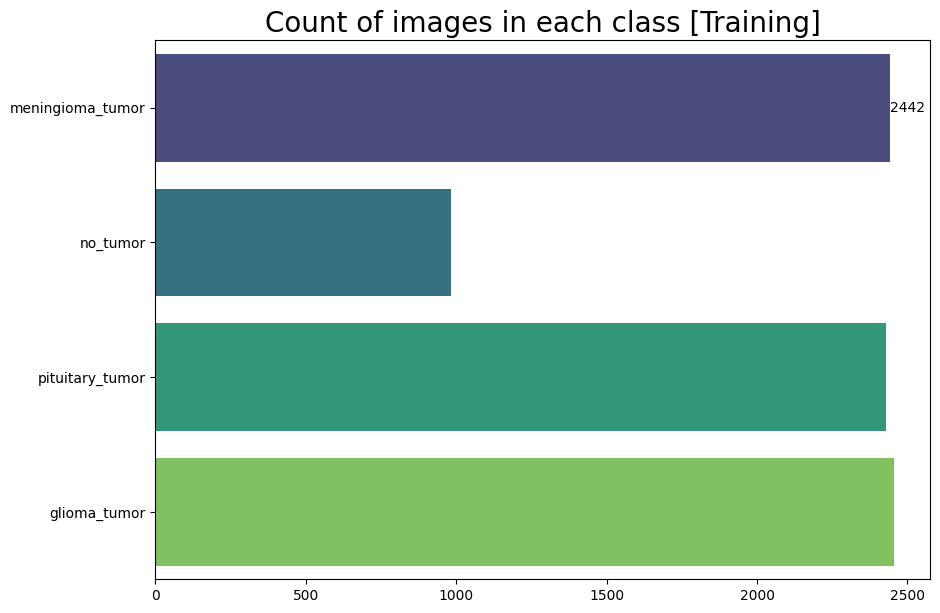

In [ ]:
#Count of images in each class in train data
plt.figure(figsize=(10,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'], palette = 'viridis')

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class [Training]', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

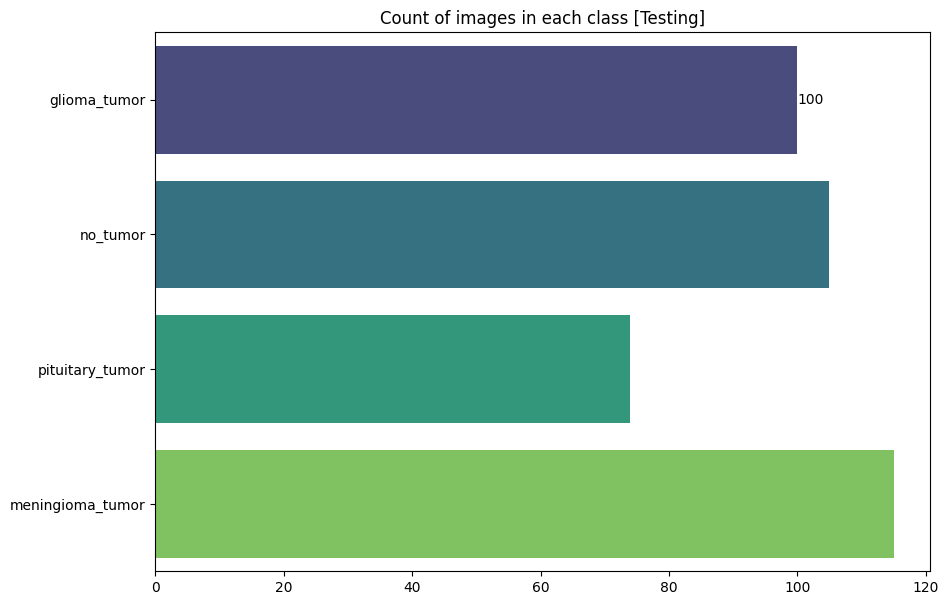

In [ ]:
#Count of each class in test data
plt.figure(figsize=(10, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class [Testing]')
ax.bar_label(ax.containers[0])

plt.show()

In [ ]:
val_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])
val_df

,Class Path,Class
161,/content/drive/MyDrive/Bitirme Projesi/Brain-T...,no_tumor
254,/content/drive/MyDrive/Bitirme Projesi/Brain-T...,pituitary_tumor
30,/content/drive/MyDrive/Bitirme Projesi/Brain-T...,glioma_tumor
239,/content/drive/MyDrive/Bitirme Projesi/Brain-T...,pituitary_tumor
145,/content/drive/MyDrive/Bitirme Projesi/Brain-T...,no_tumor
...,...,...
38,/content/drive/MyDrive/Bitirme Projesi/Brain-T...,glioma_tumor
261,/content/drive/MyDrive/Bitirme Projesi/Brain-T...,pituitary_tumor
224,/content/drive/MyDrive/Bitirme Projesi/Brain-T...,pituitary_tumor
280,/content/drive/MyDrive/Bitirme Projesi/Brain-T...,meningioma_tumor


In [ ]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-ci5lrchl
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-ci5lrchl
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00
  Created wheel for image_classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20031 sha256=80862567fd0d2e3afda9f72533abb3d4cc6b7fcb43c21e72b39da3ca79b3c6c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-9adr3alg/wheels/14/43/ed/2d68b197c5260e7fe6b7d0fab20b997b6d365f6f5732316952
Successfully built image_classifiers


In [ ]:
from classification_models.keras import Classifiers
from keras.layers import BatchNormalization, Dropout, LeakyReLU

ResNet18, preprocess_input = Classifiers.get('resnet18')
input_layer = Input(shape=(256,256,3))
base_model = ResNet18(weights='imagenet', include_top=False, input_tensor=input_layer)


x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(512)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(4, activation="softmax")(x)

resnet_model = Model(inputs=base_model.input, outputs=output)

44920640/44920640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Define training parameters
img_size=(256,256)
batch_size=32
num_classes=4



_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

val_gen = _gen.flow_from_dataframe(val_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 8307 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.


In [ ]:
#Specify input shape and num_classes
input_shape=(256,256,3)
num_classes=4 # 4 classes for our research (2 for detection)

In [ ]:
from keras.layers import BatchNormalization, Dropout, LeakyReLU

def create_model(base_model_class, input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    base_model = base_model_class(weights='imagenet', include_top=False, input_tensor=input_layer)
    # base_model.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

In [ ]:
#NasNetMobile ImageNet gibi büyük veri kümelerinde eğitilmiş hazırlıklara sahiptir.
nasnet_model=create_model(NASNetMobile,input_shape,num_classes)

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau

reduce_lr=ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=5,
    min_lr=1e-6
)


# defining callbacks
def lr_schedule(epoch):
    initial_lr = 1e-3
    drop = 0.5
    epochs_drop = 15
    return initial_lr * (drop ** (epoch // epochs_drop))

lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import CategoricalCrossentropy

for model in [resnet_model]:
    lr_schedule = ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.96,
        staircase=True
    )
    optimizer = Adam(learning_rate=lr_schedule, clipnorm=1.0)
    loss = CategoricalCrossentropy(label_smoothing=0.1)
    metrics = ["accuracy", Precision(), Recall()]
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#Training the resnet model
resnet_hist=resnet_model.fit(tr_gen,
                 validation_data=val_gen,
                 epochs=20,
                shuffle=False)

Epoch 1/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 1783s 7s/step - accuracy: 0.7187 - loss: 1.0349 - precision: 0.7535 - recall: 0.6749 - val_accuracy: 0.2741 - val_loss: 1.4623 - val_precision: 0.1081 - val_recall: 0.0203
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 45s 174ms/step - accuracy: 0.8973 - loss: 0.5873 - precision: 0.9155 - recall: 0.8766 - val_accuracy: 0.2741 - val_loss: 1.8960 - val_precision: 0.2517 - val_recall: 0.1827
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 45s 174ms/step - accuracy: 0.9368 - loss: 0.5012 - precision: 0.9527 - recall: 0.9247 - val_accuracy: 0.4670 - val_loss: 1.6009 - val_precision: 0.4716 - val_recall: 0.4213
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 46s 177ms/step - accuracy: 0.9570 - loss: 0.4583 - precision: 0.9648 - recall: 0.9479 - val_accuracy: 0.7310 - val_loss: 1.0055 - val_precision: 0.7474 - val_recall: 0.7208
Epoch 5/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 46s 176ms/step - accuracy: 0.9661 - loss: 0.4396 - precision: 0.9728 - recall: 0.9581 - val_accuracy: 0.7310 

In [ ]:
#Saving the model
resnet_model.save("/content/resnet_model.h5")


In [ ]:
import pickle

# Save the history of all models
for hist, name in zip([resnet_hist],['resnet']):
    with open(f"/content/{name}_hist.pkl", "wb") as file:
        pickle.dump(hist.history, file)

In [ ]:
import pickle
from google.colab import files

# Save the history of all models
for hist, name in zip([resnet_hist], ['resnet']):
    # Define the file path for saving
    file_path = f"/content/{name}_hist.pkl"

    # Save the model history using pickle
    with open(file_path, "wb") as file:
        pickle.dump(hist.history, file)

    # Optionally, download the file
    files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

# Load the history from the saved file
with open("/content/resnet_hist.pkl", "rb") as file:
    history = pickle.load(file)


In [ ]:
train_acc = history['accuracy']
val_acc = history['val_accuracy']
train_loss = history['loss']
val_loss = history['val_loss']


In [ ]:
epochs = range(1, len(train_acc) + 1)

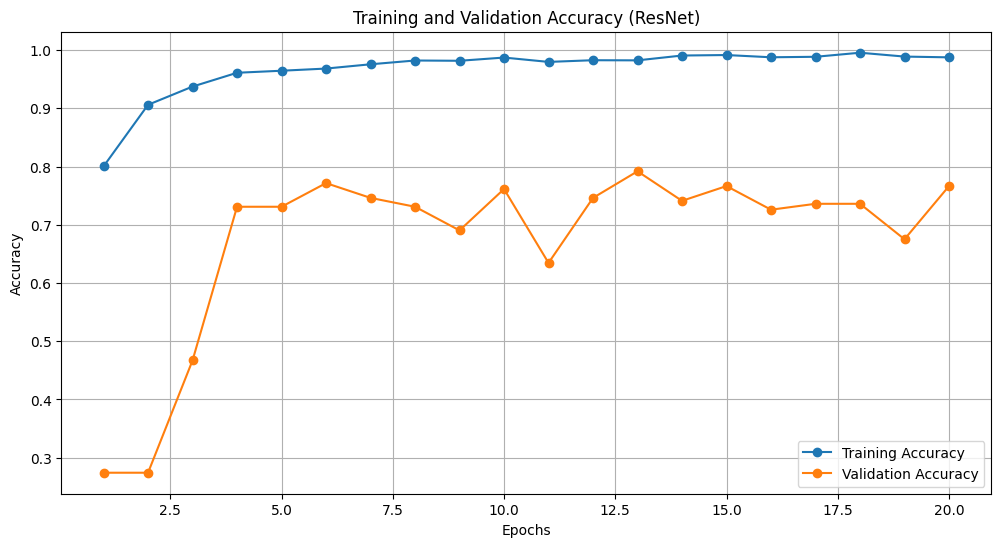

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy (ResNet)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

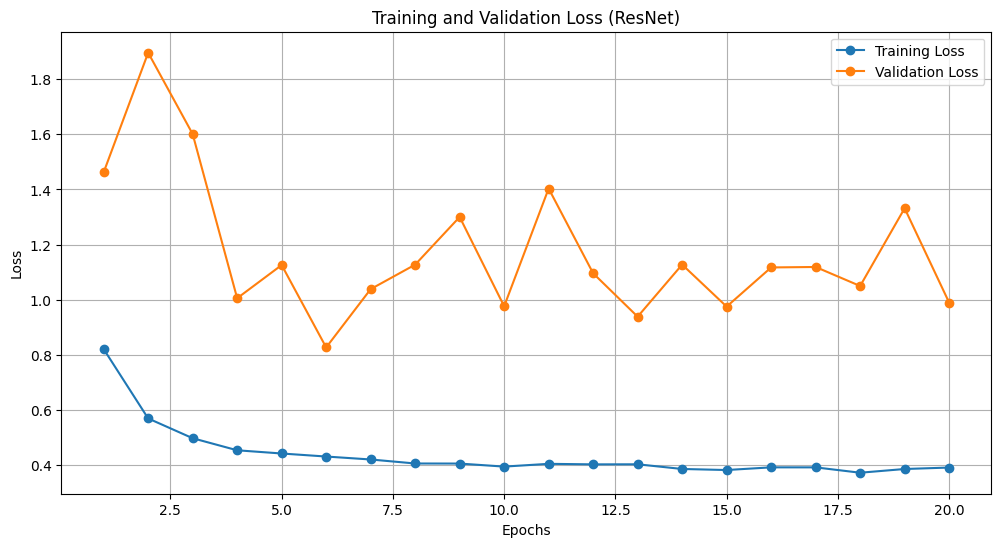

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss (ResNet)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

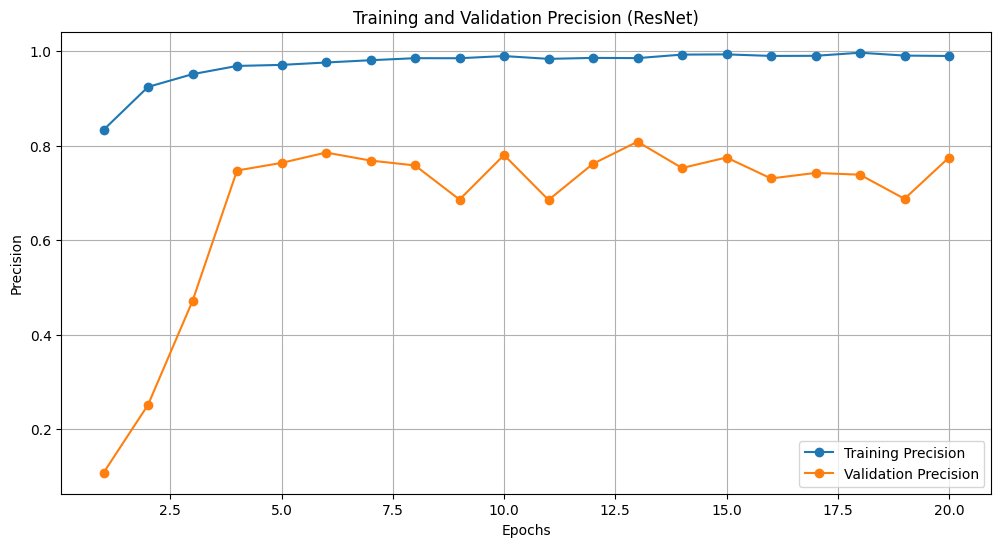

In [ ]:
if 'precision' in history and 'val_precision' in history:
    train_precision = history['precision']
    val_precision = history['val_precision']

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_precision, label='Training Precision', marker='o')
    plt.plot(epochs, val_precision, label='Validation Precision', marker='o')
    plt.title('Training and Validation Precision (ResNet)')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()


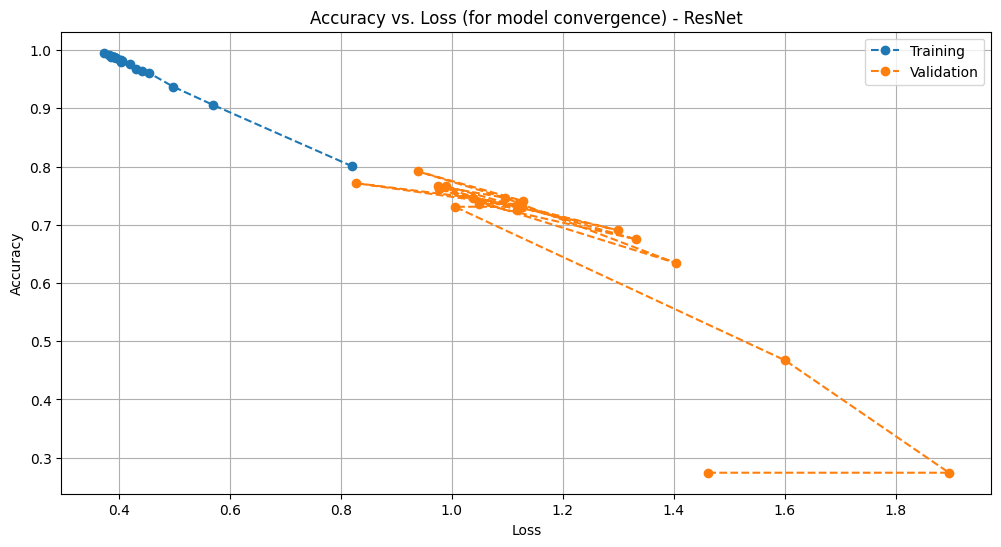

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, train_acc, label='Training', marker='o', linestyle='--')
plt.plot(val_loss, val_acc, label='Validation', marker='o', linestyle='--')
plt.title('Accuracy vs. Loss (for model convergence) - ResNet')
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
if 'time_per_epoch' in history:
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['time_per_epoch'], marker='o')
    plt.title('Time Per Epoch (ResNet)')
    plt.xlabel('Epochs')
    plt.ylabel('Time (seconds)')
    plt.grid(True)
    plt.show()

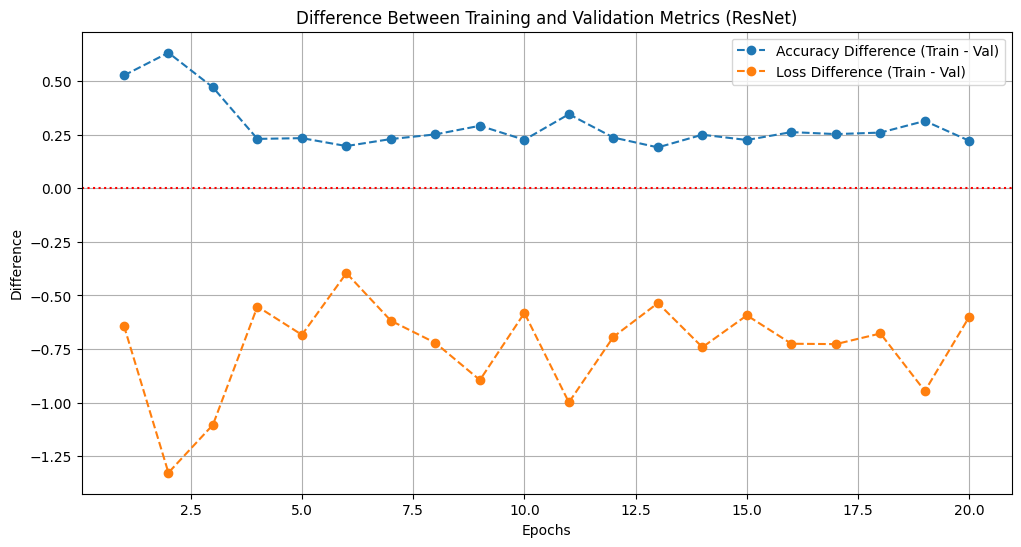

In [ ]:
# Difference Between Training and Validation Metrics
# Difference in Accuracy
acc_diff = [train - val for train, val in zip(train_acc, val_acc)]
# Difference in Loss
loss_diff = [train - val for train, val in zip(train_loss, val_loss)]

plt.figure(figsize=(12, 6))
plt.plot(epochs, acc_diff, label='Accuracy Difference (Train - Val)', marker='o', linestyle='--')
plt.plot(epochs, loss_diff, label='Loss Difference (Train - Val)', marker='o', linestyle='--')
plt.axhline(0, color='red', linestyle=':')
plt.title('Difference Between Training and Validation Metrics (ResNet)')
plt.xlabel('Epochs')
plt.ylabel('Difference')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, f1_score

13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step


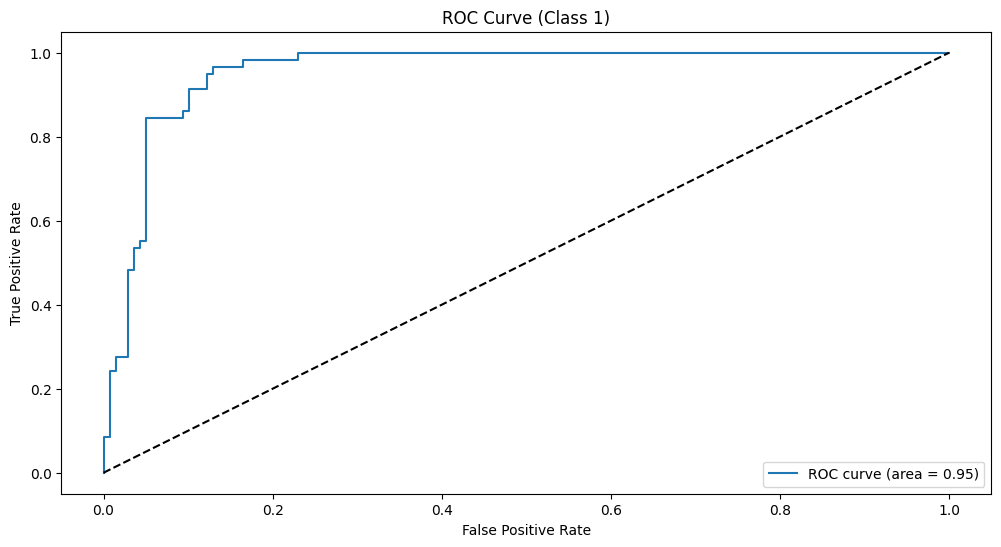

In [ ]:
#ROC-AUC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_pred_proba = resnet_model.predict(ts_gen)
# Binarize the labels for multiclass ROC curve
y_true_bin = label_binarize(ts_gen.classes, classes=np.unique(ts_gen.classes))
n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for a specific class (e.g., class 1)
plt.figure(figsize=(12, 6))
plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Class 1)')
plt.legend(loc="lower right")
plt.show()


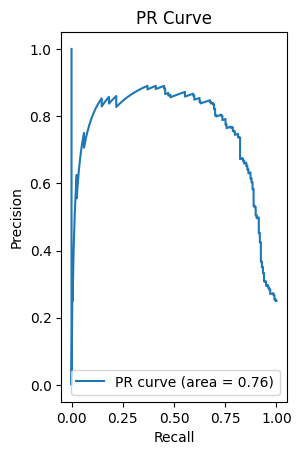

In [ ]:
#PR-AUC
precision, recall, _ = precision_recall_curve(y_true_bin.ravel(), y_pred_proba.ravel())  #Assuming binary classification for simplicity
pr_auc = average_precision_score(y_true_bin.ravel(), y_pred_proba.ravel())

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc="lower right")

plt.show()

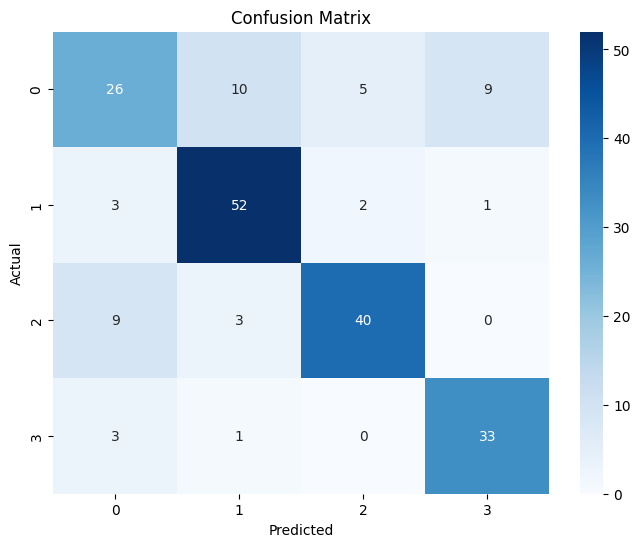

In [ ]:
#Confusion Matrix
y_pred = np.argmax(y_pred_proba, axis=1)
cm = confusion_matrix(ts_gen.classes, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#F1-Score
f1 = f1_score(ts_gen.classes, y_pred, average='weighted')
print('F1 Score:', f1)

F1 Score: 0.7602121415327572
